- PGGANの論文：[201710]Progessive Growing of GANs for Improved Quality, Stability, and Variation
- Tero Karras達, Nvidia
- https://arxiv.org/abs/1710.10196

### implement the PGGAN using TFHubの理由
- The original implementation of PGGAN took the NVIDIA researchers **one to two months to run**, which we thought was impractical for any person to run on their own, especially if you want to experiment or get something wrong.
- PGGANの実現コードが膨大で、TFHub allows us to skip over the boilerplate code and focus on the ideas that matter.

# ProGANのトレーニング方法

## トレーニングの安定性や速度：Progressive growing and smoothing of higher-resolution layers
- progressive growing.
 - 低解像度（小さい層）からどんどん**zoom in** (increase the complexity).
     - zoom inの実現は、adding extra layers.
     - increases in complexity only as we gain confidence that we are at the approximately right part of the loss space.

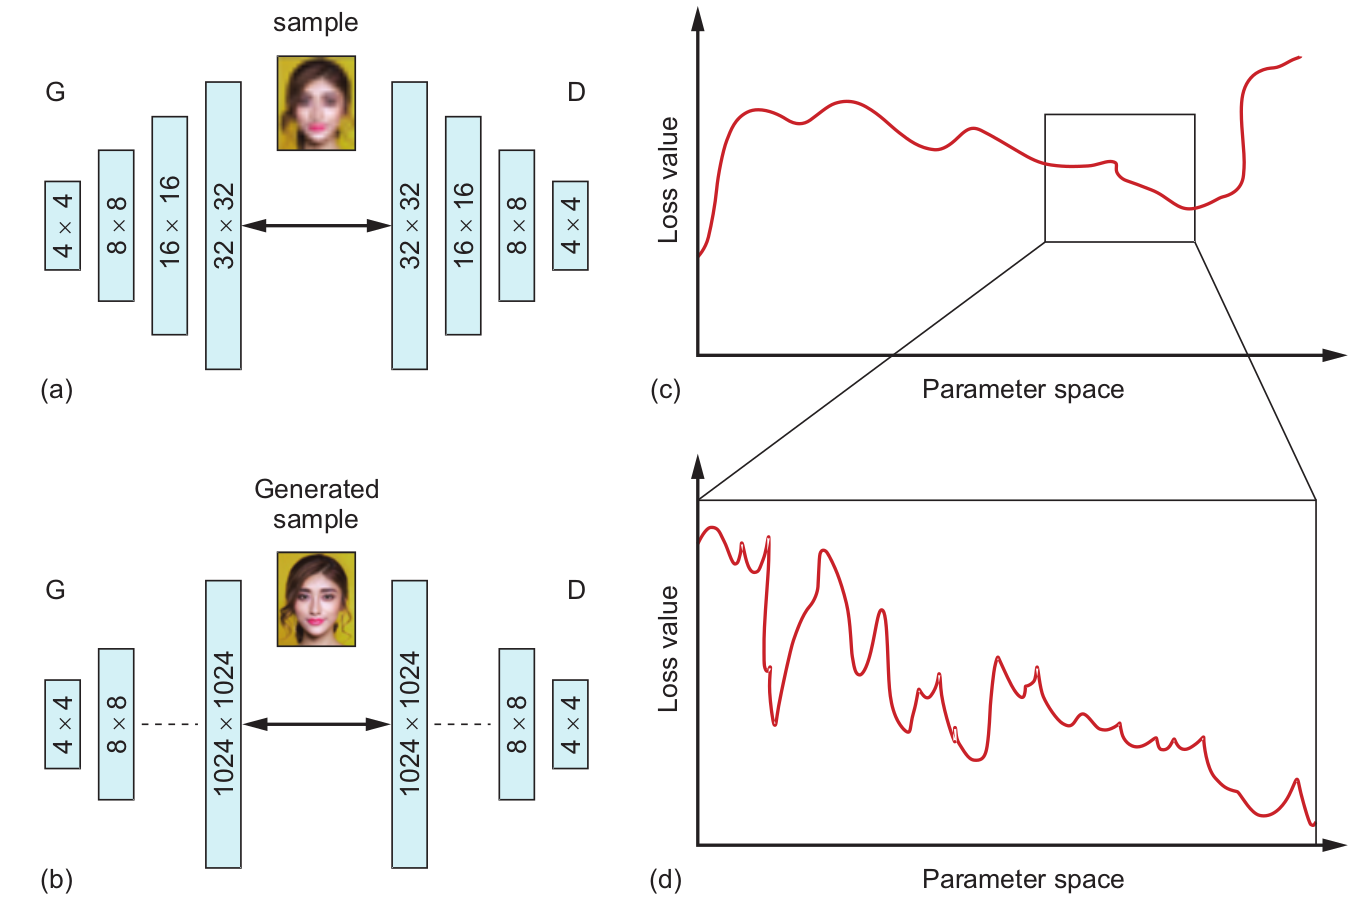

In [3]:
from IPython.display import Image
Image("img/pggan-progressive-growing-2020-02-23 21-42-23.png", width=900) 

- smoothly fade in.
 - fade inするのは低解像度の層。なぜなら、高解像度層をintroduceしたらメインは高解像度層をトレーニングするのだ。
 - なぜsmoothly fade in?
     - upon introducing even one more layer at a time, we are still introducing a massive **shock** to the training.
     - だからPGGANの発明者はsmoothly fade in trained lower resolution layers, in order to give the system **time to adapt to the higher resolution**.
 - やり方：高解像度層を導入後、一気に高解像度層通路に入れ替えるではなく、**２つ通路**の状態でトレーニングする。
     - 通路１：高解像度通路、重みは$\alpha$。
     - 通路２：学習済み低解像度通路（upscaleだけ）、重みは$1-\alpha$。パラメータなし。
         - simple nearest neighbor upscaling, which does not have any trained parameters.
     - 下記図(a)(b)(c)状態で全部自信が出るまでトレーニングする。
     - 考え方：residual block。$\alpha$はincreases linearly from 0 to 1.

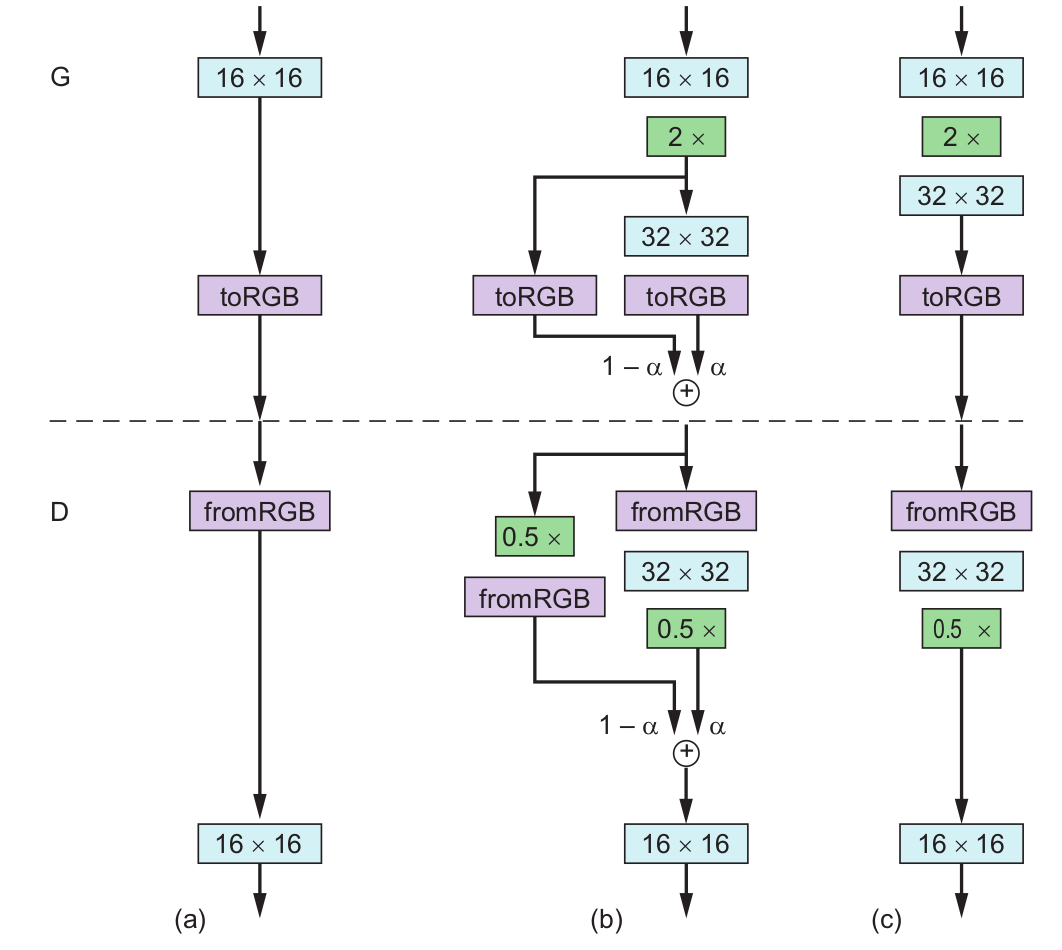

In [6]:
Image("img/pggan-smoothly-fade-in-2020-02-23 21-56-19.png", width=700)

## 画像の変化を促す：Mini-batch standard deviation
- 目的：increasing variation.
- 課題対象：mode collapse.
 - 意味：the generator collapses which produces **limited varieties of samples**.例えばgeneratorが生成した数字の中に8が全然ない。
- 対策：Discriminatorにmini-batch standard deviationに構成された１つfeature mapを追加。
- Mini-batch standard deviationの計算や使用方法：
 - scalarの計算。例えばDiscriminatorの入力tensorが[B,W,H,C]のサイズ。
 - まずはB軸（axis=0, batch_size）に対してstandard deviationを計算。つまりstddevのサイズは[W,H,C]です。
 - またwidth, height, channelsに対して、stddevの平均値(scalar)を計算する。
 - 最後はこのmean stddev scalarを使って、[B,W,H]サイズのtensorを作って、layerに１つfeature mapとして追加する。
- 小さいmini-batch standard deviationを罰する。
 - 小さいmini-batch standard deviationだったら、つまりgeneratorが生成した画像の多様性が足りない。
 - 多様性が足りないと、Discriminatorはこれらが偽物だろうと分かる。本当の画像たちだとvarianceが高いはず。
- 本のコードが間違っているところが多いそう。下記のページの実装は分かりやすい。https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/

## GANに必要な正規化：Pixel-wise feature normalization in the generator
- 超簡単。tensorのdepth軸で正規化する。
 - [BatchSize,Width,Height,Depth] tensorのDepth軸で正規化すること。
     - つまりpixelごとに正規化する。
     - $n_{x,y}=a_{x,y}/\sqrt{\frac{1}{N}\sum_{j=0}^{N-1}(a_{x,y}^j)^2+\epsilon}$.
     - $N$はthe number of feature maps.
- なぜbatch normalizationを使わない？
 - batch normalizationが解決したい課題はcovariate shift。
 - しかし、covariate shiftはGANにとって課題ではないようです。本当の課題はsignalの大きさやD,Gのお互いの競争を制限すること。(論文p4,However, we have not observed that to be an issue in GANs, and thus believe that the actual need in GANs is **constraining signal magnitudes and competition**.)
 - signalというのは各計算量でしょう。また競争というのは例えば、Gのsignalが大きくなったら、Dのsignalも大きくなりそうでしょう。
- PixelNormalizationはGeneratorにのみ適用している。
 - The explosion in the activation magnitudes leads to an arms race **only if both** networks participate.
- ToDo:
 - covariate shiftを説明できるように。
 - inception scoreを説明できるように。

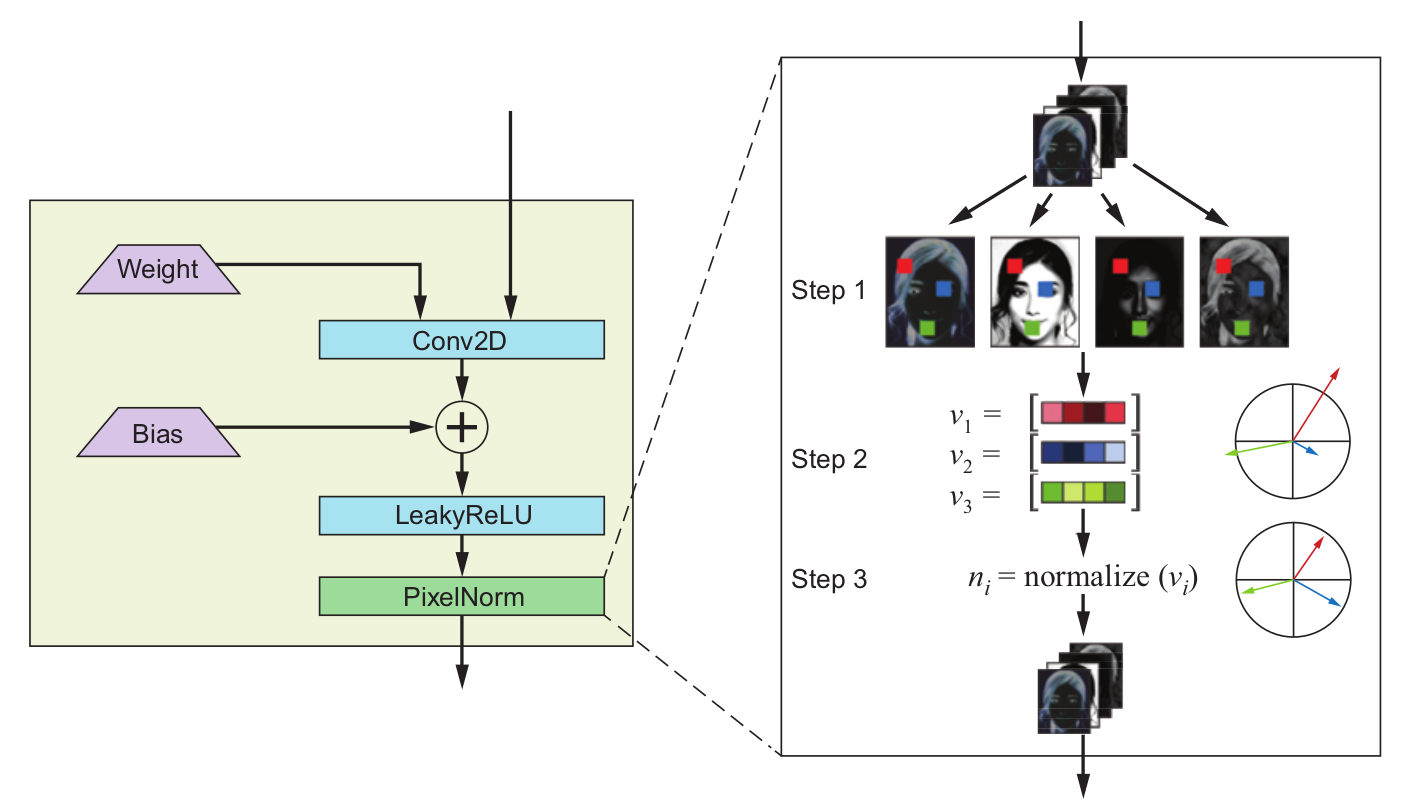

In [11]:
Image("img/pixel-wise-norm-2020-02-24 14-24-58.png", width=900)

In [2]:
import tensorflow as tf
import keras as K

## Point 1: Progressive Growing & Smoothing in of Higher Resolution Layers

In [ ]:
# 今回のコードはテストなしなので、間違っているところが多いようで、流れが分かったらOK。
def upscale_layer(layer, upscale_factor):
    # layerのサイズは[batch, height, width, channels]と期待している。
    height, width = layer.get_shape()[1:3]
    # upscale_factor倍でサイズを拡大する。
    size = (upscale_factor * height, upscale_factor * width)
    upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
    return upscale_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
    # list_of_layers: tensors ordered by size。つまりlast layerは[-2]、最新層は[-1]。
    last_fully_trained_layer = list_of_layers[-2]
    # 学習済みの前の層を2倍拡大。
    last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)
    
    larger_native_layer = list_of_layers[-1]
    assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()
    
    new_layer = (1-alpha) * last_layer_upscaled + alpha * larger_native_layer
    
    return new_layer

## Point 4: Pixel-wise Feature Normalization

In [ ]:
# **kwargsは任意keyworded（key=value）入力。
def pixelwise_feat_norm(inputs, **kwargs):
    # axis=-1はchannels軸だ。もしinputsのサイズが[B,H,W,C]だったら、normalization_constantのサイズは[B,H,W,1]になる。
    normalization_constant = K.backend.sqrt(K.backend.mean(
        inputs**2, axis=-1, keepdims=True) + 1.0e-8)
    return inputs / normalization_constant

## Step 1: Running PGGAN from tensorflow Hub
- tensorflow Hubのインストール
 - pip install tensorflow-hub
- 下記のtensorflow-hubページからfiltersでネットワークを探せる。
 - https://tfhub.dev/s
 - 例えばprogressive ganを探して、Googleが用意したprogan-128しかない。これを使おう。

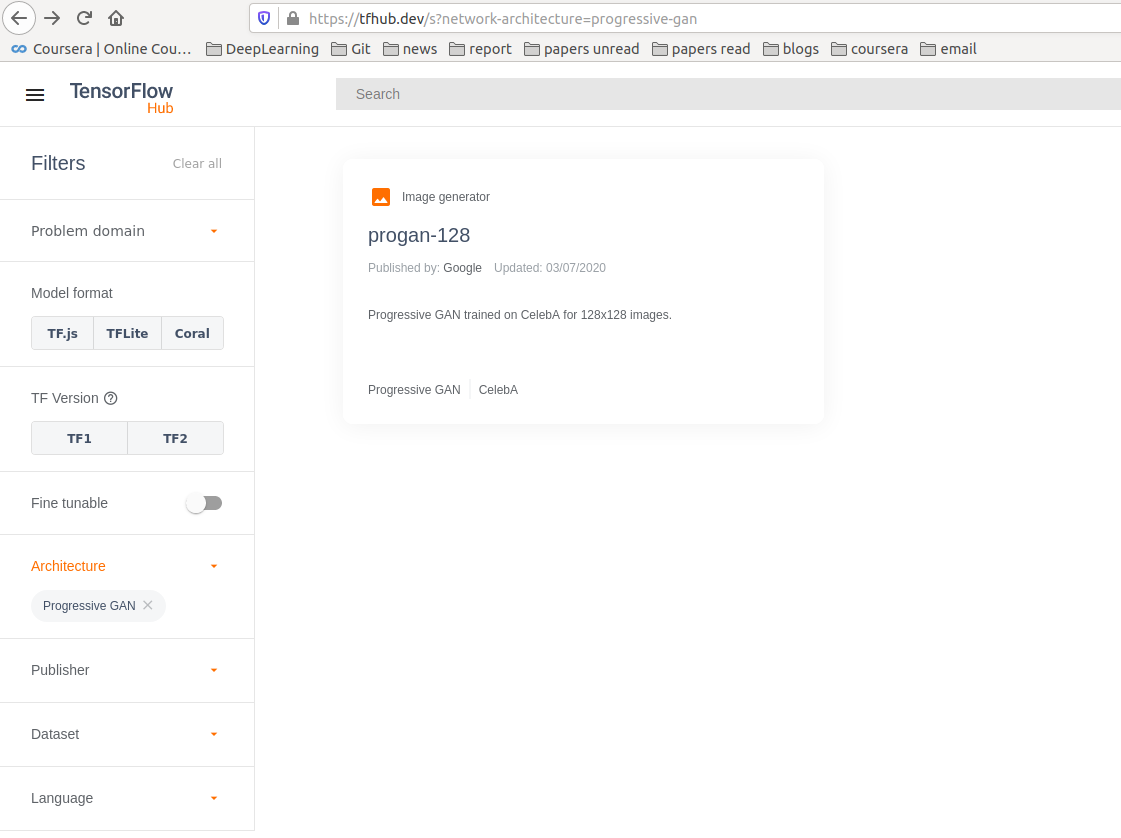

In [5]:
Image("img/tensorflow-hub-2020-03-07 12-07-36.png", width=800)

- 基本の使い方はprogan-128ページに既に書いてある。https://tfhub.dev/google/progan-128/1
 - Maps from a 512-dimensional latent space to images. During training, the latent space vectors were sampled from a normal distribution.
 - Module takes `<Tensor(tf.float32, shape=[?, 512])>`, representing a batch of latent vectors as input, and outputs `<Tensor(tf.float32, shape=[?, 128, 128, 3])>` representing a batch of RGB images.
```python
# Generate 20 random samples.
generate = hub.Module("https://tfhub.dev/google/progan-128/1")
images = generate(tf.random_normal([20, 512]))
```
 - 20はサンプル数、512はlatentのサイズ。
- **ToDo**:
 - colabの使い方。
 - virtualenvの使い方。
 - tensorflow 2の実践。

In [2]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow as tf

- withの意味
 - `with` statements open a **resource** and guarantee that the resource will be closed when the `with` block completes, regardless of how the block completes.
- tensorflowのGraphやSessionの意味：
 - Sessionページの例を見れば分かりやすい。https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session
 - Graphは操作の定義です。
 - Sessionは操作の実施です。
 - C++と比べると、Graphはクラスの定義です、Sessionはクラスのinstance化でしょう。

```python
# Build a graph.
a = tf.constant(5.0)
b = tf.constant(6.0)
c = a * b

# Launch the graph in a session.
sess = tf.compat.v1.Session()

# Evaluate the tensor `c`.
print(sess.run(c))
```

- 生成した画像は、latentのscaleと関係ないのは試した。下記のlatent_vectorを2倍にしても同じ画像が出る。
 - これは、直感的に説明すると、どんなscaleでも結局[0,255]（もしくは[0,1]）にscaleされるからです。

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


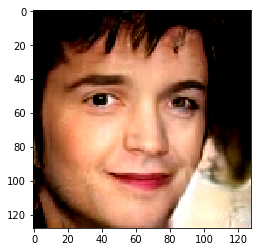

In [12]:
with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    # Generatorのinput(latent)を用意する。
    latent_dim = 512
    latent_vector = tf.random_normal([1, latent_dim], seed=1340)
    # progan128を使って画像を生成する。
    interpolated_images = module(latent_vector)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        image_out = session.run(interpolated_images)

plt.imshow(image_out.reshape(128,128,3))
plt.show()

## 遊び１：latent Aからlatent Bまで連続latent spaceでの生成された画像（latent space interpolation）
- scikit-imageのインストール：`pip install scikit-image`.
- ２つ遊びは全部tensorhub progan128ページ（https://tfhub.dev/google/progan-128/1　）のcolab notebook("Open Colab Notebook")を参考している。https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb


In [15]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

latent_dim = 512

def interpolate_hypersphere(v1, v2, num_steps):
    '''latent v1からlatent v2まで等間隔内挿する。生成された画像はlatentのscaleと関係ない。
    等間隔を保証するため、先にv2をv1と同じscaleにする。また、内挿したvectorも全部v1と同じscaleにする。'''
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)
    
    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

# Given a set of images, show an animation.
def animate(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    with open('./animation.gif','rb') as f:
        display.display(display.Image(data=f.read()))
        
def display_image(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)

# Display multiple images in the same figure.
def display_images(images, captions=None):
    num_horizontally = 5
    # //:floor division.
    f, axes = plt.subplots(len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
    for i in range(len(images)):
        axes[i // num_horizontally, i % num_horizontally].axis("off")
        if captions is not None:
            axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
        axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
    f.tight_layout()

tf.logging.set_verbosity(tf.logging.ERROR)

In [20]:
def interpolate_between_vectors(seed_1=3, seed_2=1, num_steps=50):
    with tf.Graph().as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        
        # Change the seed to get different random vectors.
        v1 = tf.random_normal([latent_dim], seed=seed_1)
        v2 = tf.random_normal([latent_dim], seed=seed_2)
        
        # Creates a tensor with 50 steps of interpolation between v1 and v2.
        vectors = interpolate_hypersphere(v1, v2, num_steps)
        
        # Uses module to generate images from the latent space
        interpolated_images = module(vectors)
        
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            interpolated_images_out = session.run(interpolated_images)
            
        # v1からv2へ生成した画像をgifにする。
        animate(interpolated_images_out)

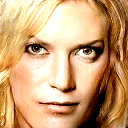

In [21]:
interpolate_between_vectors(seed_1=3, seed_2=1, num_steps=50)

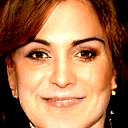

In [23]:
interpolate_between_vectors(seed_1=4, seed_2=5, num_steps=50)

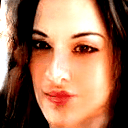

In [24]:
interpolate_between_vectors(seed_1=6,seed_2=7,num_steps=50)

## 遊び２：target画像と一番近い、Generatorが生成できる、画像を探す
- target写真がそもそもGeneratorが生成したら（つまりfrom the module space）、合理的な一番近い画像を探せるけど。
- そうじゃないと、近いと思われる写真は見つからないそうです。

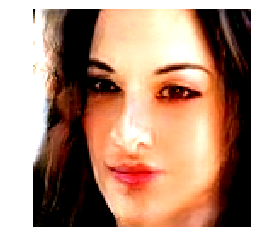

In [74]:
def get_module_space_image(seed=6):
    with tf.Graph().as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        vector = tf.random_normal([1, latent_dim], seed=seed)
        images = module(vector)
        
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            image_out = session.run(images)[0]
    return image_out

target_image = get_module_space_image()
display_image(target_image)

- target画像とのloss functionを定義して、gradient descentでlossを最小化する。

In [98]:
def find_closest_latent_vector(num_optimization_steps, seed=7):
    images = []
    losses = []
    with tf.Graph().as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        initial_vector = tf.random_normal([1, latent_dim], seed=seed)
        # vectorはgradient descentで最適化する対象
        vector = tf.get_variable("vector", initializer=initial_vector)
        image = module(vector)
        target_image_difference = tf.reduce_sum(tf.losses.absolute_difference(image[0], target_image[:,:,:3]))
        # vectorのnormの平均値はsqrt(latent_dim)なので、vectorをトレーニング中もできるだけnormはsqrt(latent_dim)に近いまま。
        regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
        loss = target_image_difference + regularizer
        optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
        train = optimizer.minimize(loss)
        
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            for _ in range(num_optimization_steps):
                _, loss_out, im_out = session.run([train, loss, image])
                images.append(im_out[0])
                losses.append(loss_out)
        return images, losses

- N回正規分布からサンプリングしたvectorのnormの平均値は$\sqrt{N}$です。（平方根へいほうこん）
 - 例えば$\sqrt{512}=22.627416998$

In [39]:
vector = tf.random_normal([1, 512])
with tf.Session() as sess:
    print(tf.norm(vector).eval())

22.410238


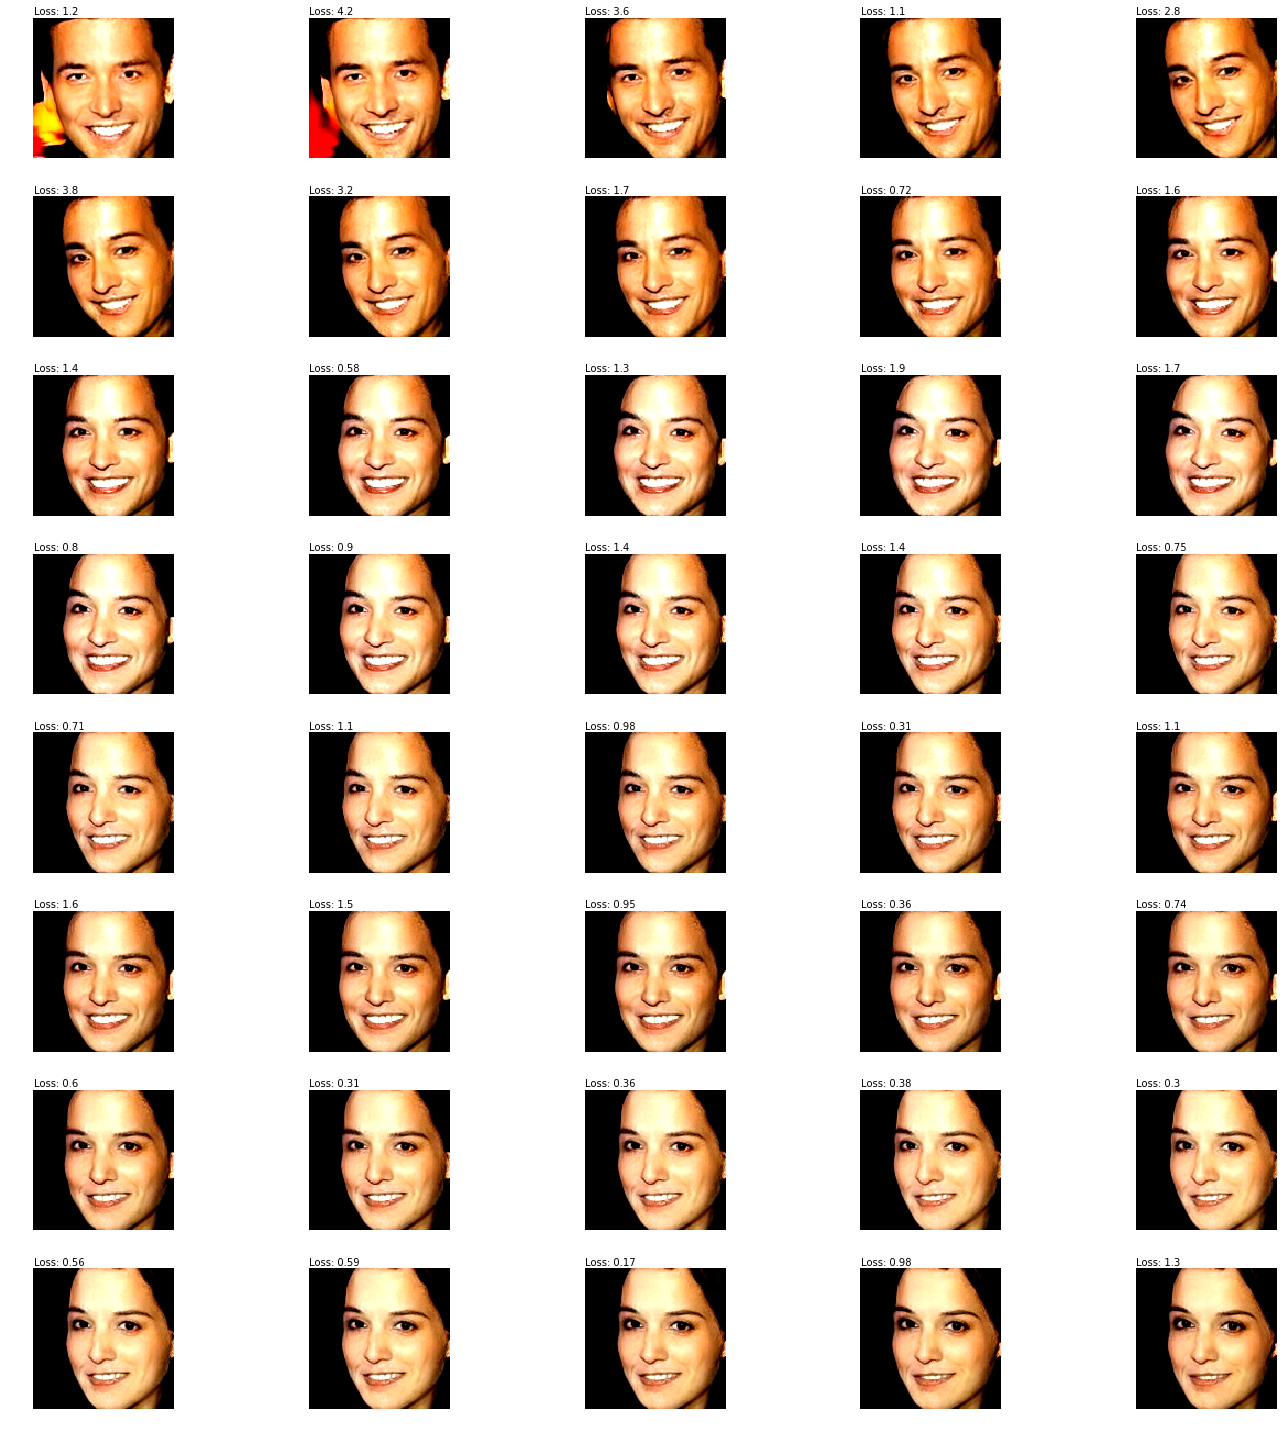

In [100]:
target_image = get_module_space_image()
result = find_closest_latent_vector(num_optimization_steps=40, seed=100)
captions = [ f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)

(880, 550, 3)


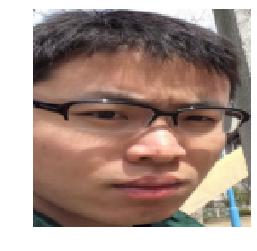

In [120]:
image = imageio.imread("./sen2.jpg")
image = image[300:1180,:550]
print(image.shape)
target_image = transform.resize(image, [128, 128])
display_image(target_image)

In [109]:
def find_closest_latent_vector2(num_optimization_steps, seed=7):
    images = []
    losses = []
    with tf.Graph().as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        initial_vector = tf.random_normal([1, latent_dim], seed=seed)
        # vectorはgradient descentで最適化する対象
        vector = tf.get_variable("vector", initializer=initial_vector)
        image = module(vector)
        target_image_difference = tf.reduce_sum(tf.losses.mean_squared_error(image[0], target_image[:,:,:3]))
        # vectorのnormの平均値はsqrt(latent_dim)なので、vectorをトレーニング中もできるだけnormはsqrt(latent_dim)に近いまま。
        regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
        loss = target_image_difference + regularizer
        optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
        train = optimizer.minimize(loss)
        
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            for _ in range(num_optimization_steps):
                _, loss_out, im_out = session.run([train, loss, image])
                images.append(im_out[0])
                losses.append(loss_out)
        return images, losses

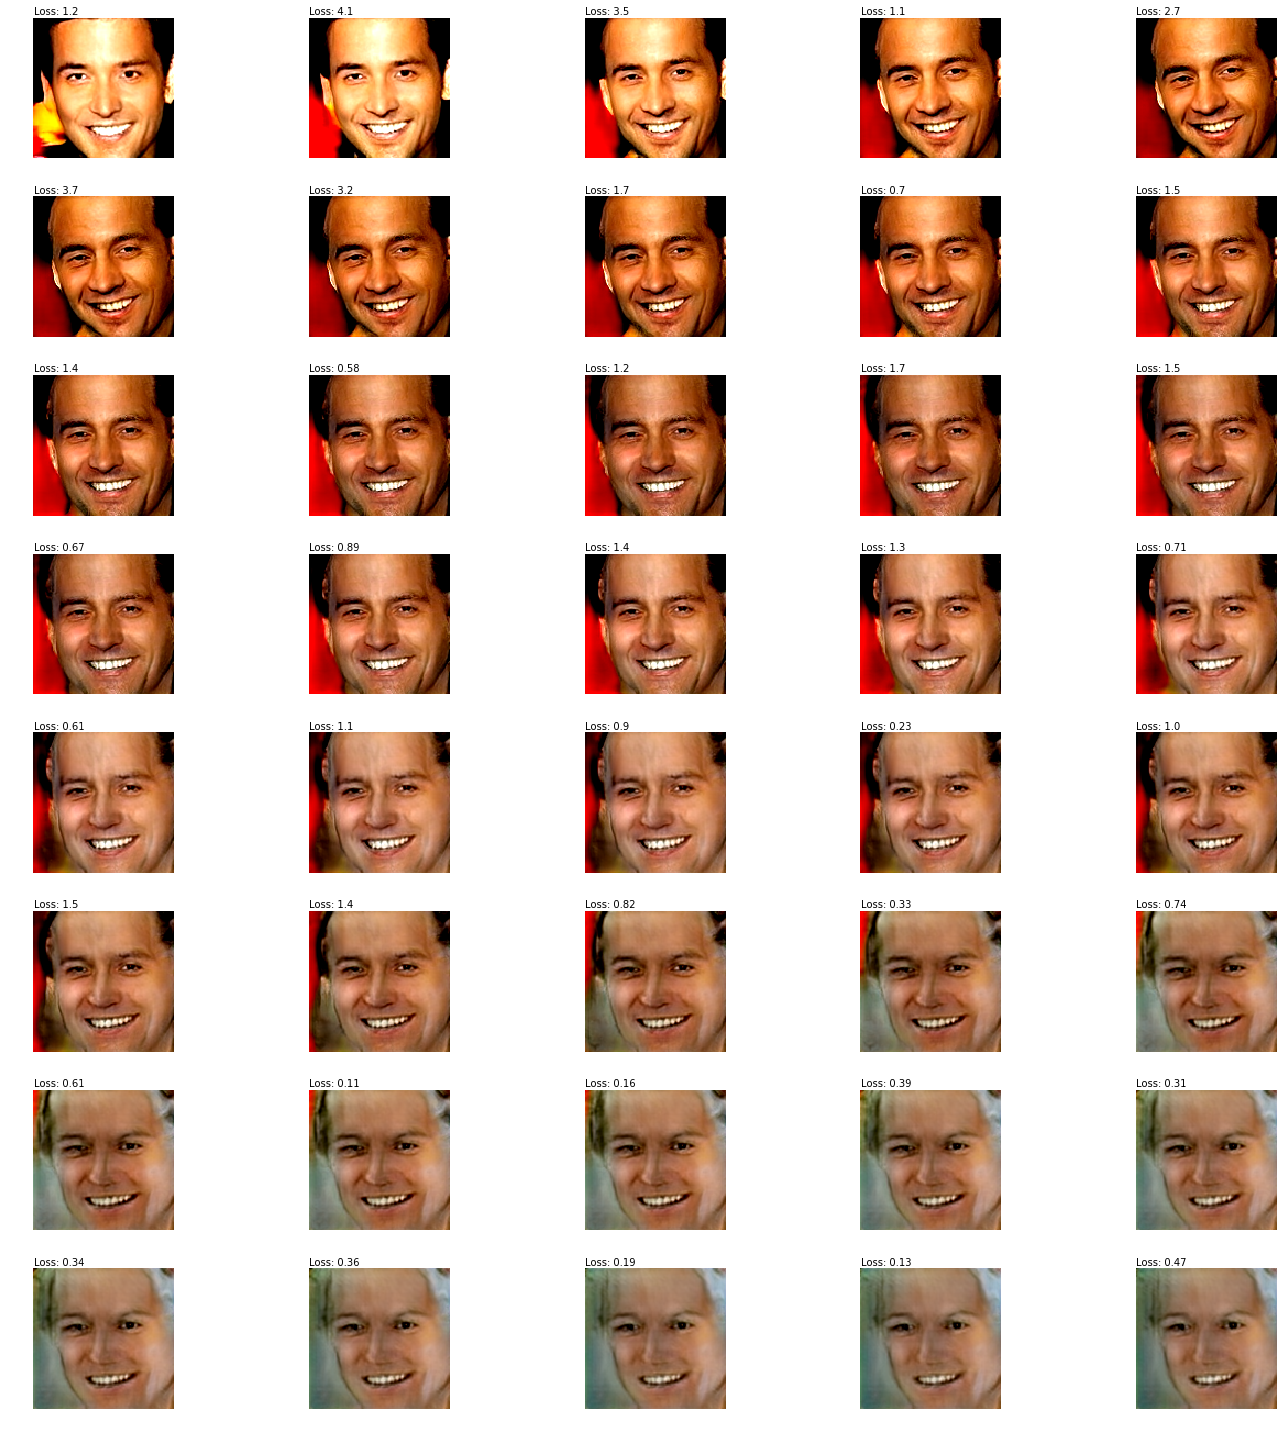

In [121]:
result = find_closest_latent_vector2(num_optimization_steps=40, seed=100)
captions = [ f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)